# 1 - Introduction

## 1.1 - Task

The task is to develop a machine learning system for classifying histopathology images of cancerous cells that can perform two types of classifications:

1) Classify if an image of a cell is cancerous, and

2) Classify what cell type a given image is (fibroblast, inflammatory,
epithelial, others).

##1.2 - Approach

An initial exploration of the provided datasets will be conducted first to gain an understanding of them with regard to their contents, correctness, class balance, and suitability for each task, as well checking for missing data and identifying relationships between classes. Using knowledge of the data gained from the EDA, suitable performance metrics will be evaluated to determine the most appropriate way to measure each model's performance.

Baseline models will be set up for each task using a neural network model, with the model trained and tested on the dataset identified to be appropriate for each task. Iterations and improvements on the baseline model will be conducted and discussed with model changes justiftied as the research progresses. Several model types may be evaluated as alternatives to a Neural Network based mode. Deep learning will be evaluated as an improvement method to the baseline models.

Given the slightly different feature set of the two provided text label datasets, the potential for utilising one dataset to aid in the classification of the other will be explored, validated, and potentially used to improve outcomes for either or both tasks.

Finally, an comparitive analysis of how both classification tasks were approached will be provided, along with results and performance from each of the final models.



# 2 - Setup

## 2.1 - Import Libraries

In [ ]:
# Importing Packages
import gc
import os
import cv2
import pathlib
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

RANDOM_SEED = 98651

## 2.2 - Load Text Datasets


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Find where the data file is stored on your google drive
!cp /content/drive/'My Drive'/ML_A2/Image_classification_data.zip .
!unzip -q -o Image_classification_data.zip # Extract files
!rm Image_classification_data.zip
!ls # Check file contents

data_labels_extraData.csv  drive     patch_images
data_labels_mainData.csv   __MACOSX  sample_data


In [ ]:
# Load text features
df_main = pd.read_csv("./data_labels_mainData.csv", delimiter=',')
df_extra = pd.read_csv("./data_labels_extraData.csv", delimiter=',')

In [ ]:
df_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


## 2.3 - Preview Images

Found 20280 files belonging to 1 classes.


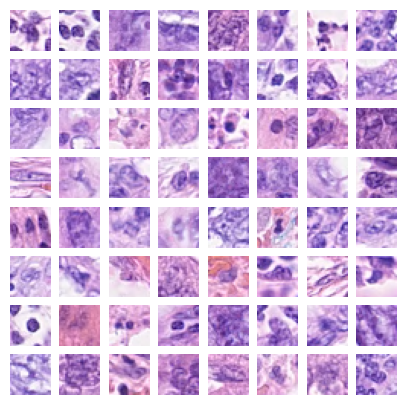

In [ ]:
# Load images (for preliminary display only)
image_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./patch_images", image_size=(27, 27), batch_size=64, labels=None
)
plt.figure(figsize=(5, 5))
for images in image_ds.take(1):
  for i in range(64):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Check for missing images by comparing filenames from 'DataFrame' with our directory
image_directory = './patch_images'
image_filenames = set(df_main['ImageName'].values)
actual_image_files = set(os.listdir(image_directory))

missing_images = image_filenames.difference(actual_image_files)

if missing_images:
    print(f"Total missing images: {len(missing_images)}")
    print("Missing image filenames:")
    for img in missing_images:
        print(img)
else:
    print("No missing images found.")

No missing images found.


Match values in "ImageName" column of the DataFrame

In [ ]:
img_details = []
for images in df_main['ImageName']:
  #with Image.open('patch_images/' + images) as img:
        #data = np.array(img).ravel()
    data = mpimg.imread('patch_images/'+ images)
    img_details.append(data.ravel())

df_main['ImageData'] = img_details

df_main.head(10)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,ImageData
0,22405,1,22405.png,fibroblast,0,0,"[0.9490196, 0.8352941, 0.92941177, 0.9372549, ..."
1,22406,1,22406.png,fibroblast,0,0,"[0.8666667, 0.6862745, 0.827451, 0.8784314, 0...."
2,22407,1,22407.png,fibroblast,0,0,"[0.96862745, 0.9529412, 0.96862745, 0.972549, ..."
3,22408,1,22408.png,fibroblast,0,0,"[0.9529412, 0.9490196, 0.9490196, 0.9529412, 0..."
4,22409,1,22409.png,fibroblast,0,0,"[0.7411765, 0.50980395, 0.7411765, 0.7294118, ..."
5,22410,1,22410.png,fibroblast,0,0,"[0.72156864, 0.48235294, 0.74509805, 0.7137255..."
6,22411,1,22411.png,fibroblast,0,0,"[0.83137256, 0.59607846, 0.81960785, 0.8666667..."
7,22412,1,22412.png,fibroblast,0,0,"[0.8627451, 0.6862745, 0.88235295, 0.8666667, ..."
8,22413,1,22413.png,fibroblast,0,0,"[0.85882354, 0.6901961, 0.8666667, 0.8352941, ..."
9,22414,1,22414.png,fibroblast,0,0,"[0.9607843, 0.95686275, 0.9529412, 0.9607843, ..."


## 2.4 - Function definitions

Utility methods are defined here to reduce code duplication.



In [ ]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()


In [ ]:
def image_labels(col, value):
    img_labels = df_main[df_main[col] == value]
    img_labels.reset_index(drop=True, inplace=True)

    for i, images in enumerate(img_labels.ImageName):
        if i == 20: break

        img = img_labels['ImageData'][i]
        img.resize(27,27,3)
        plt.subplot(5, 4, i+1)
        plt.imshow(img)

The following 3 functions are implemented to allow f1 to be passed to keras.model.compile as a custom metric:

In [ ]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


In [ ]:
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

##2.5 - Global pre-processing

ImageName column values will be prefixed with the full directory path (`./patch_images/[ImageName]`) to aid batch loading images in the two tasks ahead. No other global preprocessing will be applied as there are two tasks; each task may have further specific preprocessing applied.


In [ ]:
df_main['ImageName'] = './patch_images/' + df_main['ImageName'].astype(str)
df_extra['ImageName'] = './patch_images/' + df_extra['ImageName'].astype(str)

# 3 - Exploratory Data Analysis

Text datasets mainData extraData are analysed in terms of class and subclass balance from the perspective of suitability for both tasks:

Task 1 (binary isCancerous classification), and Task 2 (multiclass celltypeName classification).

## 3.1 - mainData EDA


In [ ]:
df_main.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


In [ ]:
df_main.head(10)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,ImageData
0,22405,1,./patch_images/22405.png,fibroblast,0,0,"[0.9490196, 0.8352941, 0.92941177, 0.9372549, ..."
1,22406,1,./patch_images/22406.png,fibroblast,0,0,"[0.8666667, 0.6862745, 0.827451, 0.8784314, 0...."
2,22407,1,./patch_images/22407.png,fibroblast,0,0,"[0.96862745, 0.9529412, 0.96862745, 0.972549, ..."
3,22408,1,./patch_images/22408.png,fibroblast,0,0,"[0.9529412, 0.9490196, 0.9490196, 0.9529412, 0..."
4,22409,1,./patch_images/22409.png,fibroblast,0,0,"[0.7411765, 0.50980395, 0.7411765, 0.7294118, ..."
5,22410,1,./patch_images/22410.png,fibroblast,0,0,"[0.72156864, 0.48235294, 0.74509805, 0.7137255..."
6,22411,1,./patch_images/22411.png,fibroblast,0,0,"[0.83137256, 0.59607846, 0.81960785, 0.8666667..."
7,22412,1,./patch_images/22412.png,fibroblast,0,0,"[0.8627451, 0.6862745, 0.88235295, 0.8666667, ..."
8,22413,1,./patch_images/22413.png,fibroblast,0,0,"[0.85882354, 0.6901961, 0.8666667, 0.8352941, ..."
9,22414,1,./patch_images/22414.png,fibroblast,0,0,"[0.9607843, 0.95686275, 0.9529412, 0.9607843, ..."


In [ ]:
# Check for missing values in mainData
print("\nMain Data Missing Values:")
print(df_main.isnull().sum())

df_main


Main Data Missing Values:
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
ImageData       0
dtype: int64


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,ImageData
0,22405,1,./patch_images/22405.png,fibroblast,0,0,"[0.9490196, 0.8352941, 0.92941177, 0.9372549, ..."
1,22406,1,./patch_images/22406.png,fibroblast,0,0,"[0.8666667, 0.6862745, 0.827451, 0.8784314, 0...."
2,22407,1,./patch_images/22407.png,fibroblast,0,0,"[0.96862745, 0.9529412, 0.96862745, 0.972549, ..."
3,22408,1,./patch_images/22408.png,fibroblast,0,0,"[0.9529412, 0.9490196, 0.9490196, 0.9529412, 0..."
4,22409,1,./patch_images/22409.png,fibroblast,0,0,"[0.7411765, 0.50980395, 0.7411765, 0.7294118, ..."
...,...,...,...,...,...,...,...
9891,1625,60,./patch_images/1625.png,epithelial,2,1,"[0.67058825, 0.5411765, 0.7058824, 0.8509804, ..."
9892,1626,60,./patch_images/1626.png,epithelial,2,1,"[0.83137256, 0.6784314, 0.89411765, 0.7254902,..."
9893,1627,60,./patch_images/1627.png,epithelial,2,1,"[0.6862745, 0.5529412, 0.75686276, 0.76862746,..."
9894,1628,60,./patch_images/1628.png,epithelial,2,1,"[0.8901961, 0.7921569, 0.9098039, 0.6901961, 0..."


In [ ]:
# Check class balance with regard to task 1
print("\nClass balance of data_labels_mainData.csv from perspective of task 1:\n")
print("Samples per category:\n")
print(df_main.isCancerous.value_counts())

# Check class balance with regard to task 2
print("\nClass balance of data_labels_mainData.csv from perspective of task 2:\n")
print("Categories: ", df_main['cellTypeName'].unique(), "\n")
print("Samples per category:\n")
print(df_main.cellTypeName.value_counts(), "\n\n")


df_main['cellTypeName_isCancerous'] = df_main['cellTypeName'] + "_" + df_main['isCancerous'].astype(str)
print(df_main.cellTypeName_isCancerous.value_counts())


Class balance of data_labels_mainData.csv from perspective of task 1:

Samples per category:

0    5817
1    4079
Name: isCancerous, dtype: int64

Class balance of data_labels_mainData.csv from perspective of task 2:

Categories:  ['fibroblast' 'inflammatory' 'others' 'epithelial'] 

Samples per category:

epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: cellTypeName, dtype: int64 


epithelial_1      4079
inflammatory_0    2543
fibroblast_0      1888
others_0          1386
Name: cellTypeName_isCancerous, dtype: int64


Bucketing the categories to examine the distribution of isCancerous and cell-type labels.

isCancerous      0     1
cellTypeName            
epithelial       0  4079
fibroblast    1888     0
inflammatory  2543     0
others        1386     0 



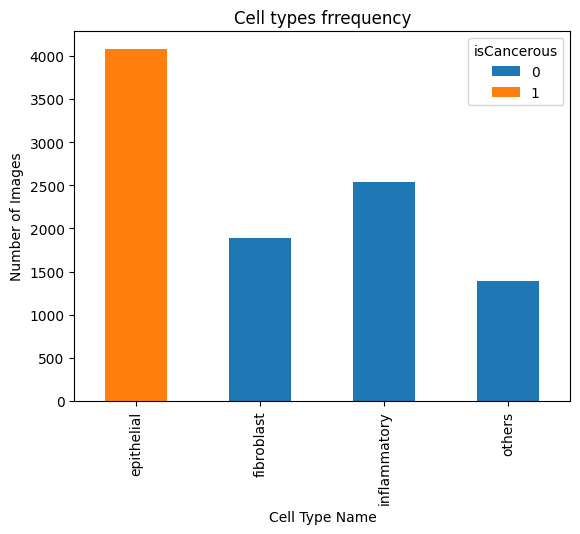

In [ ]:

# Cross-tabulation table
ct = pd.crosstab(df_main['cellTypeName'], 
                 df_main['isCancerous'])
print(ct,"\n")

# Stacked bar plot
ct.plot(kind='bar', stacked=True,title='Cell types frrequency', xlabel='Cell Type Name', ylabel='Number of Images')
plt.show()

Preview Cancerous Images

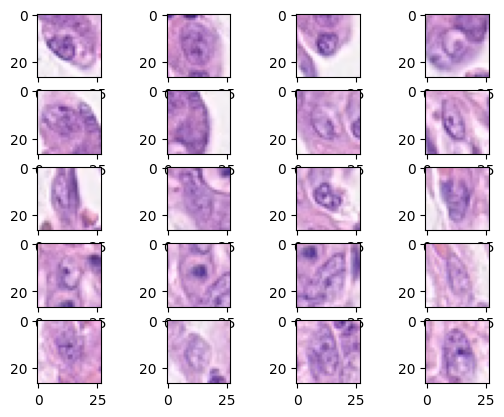

In [ ]:
image_labels('isCancerous', 1)

Preview Non-Cancerous Images

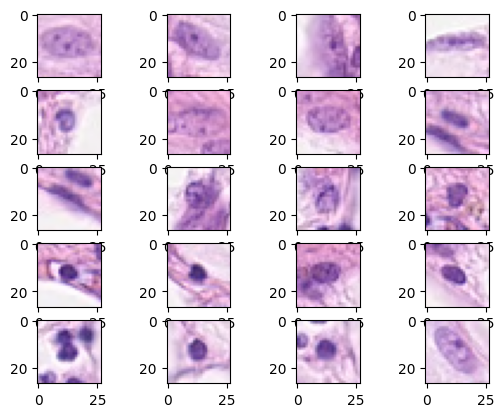

In [ ]:
image_labels('isCancerous', 0)

#### 3.1.1 - Observations for mainData

Key findings:
- There are more Epithelial cell types than other cell types.
- Epithelial cell types are all classified as cancerous in mainData.
- Other individual cell types are all classified all non-cancerous.

For the first 60 patients (mainData), there are more samples of non-cancerous (0) than cancerous cells (1). 

There was a 100% occurrence of Epithelial cells being cancerous in mainData.

Epithelial cells are not always cancerous in the population of all humans whith cancer, despite the sampling in mainData indicating so. For example, all humans have epithelial cells in their bodies, and many do not have cancer. Consequently, if there are non-cancerous epithelial cells present in the test set, the system could be predisposed to incorrectly categorize them as cancerous. This same bias could apply to the other cell types, where the model system may be inclined to classify them as non-cancerous even if they become cancerous.

The distribution of cellType labels in your dataset reveals that there is an uneven distribution of samples across different classes. 

These imbalances can be further highlighted by examining the intersection of isCancerous and cellTypeName features:


In [ ]:
# Check cellTypeName:isCancerous balance
print("\ncellTypeName:isCancerous matchup\n")
df_main['cellTypeName_isCancerous'] = df_main['cellTypeName'] + "_" + df_main['isCancerous'].astype(str)
print(df_main.cellTypeName_isCancerous.unique())


cellTypeName:isCancerous matchup

['fibroblast_0' 'inflammatory_0' 'others_0' 'epithelial_1']


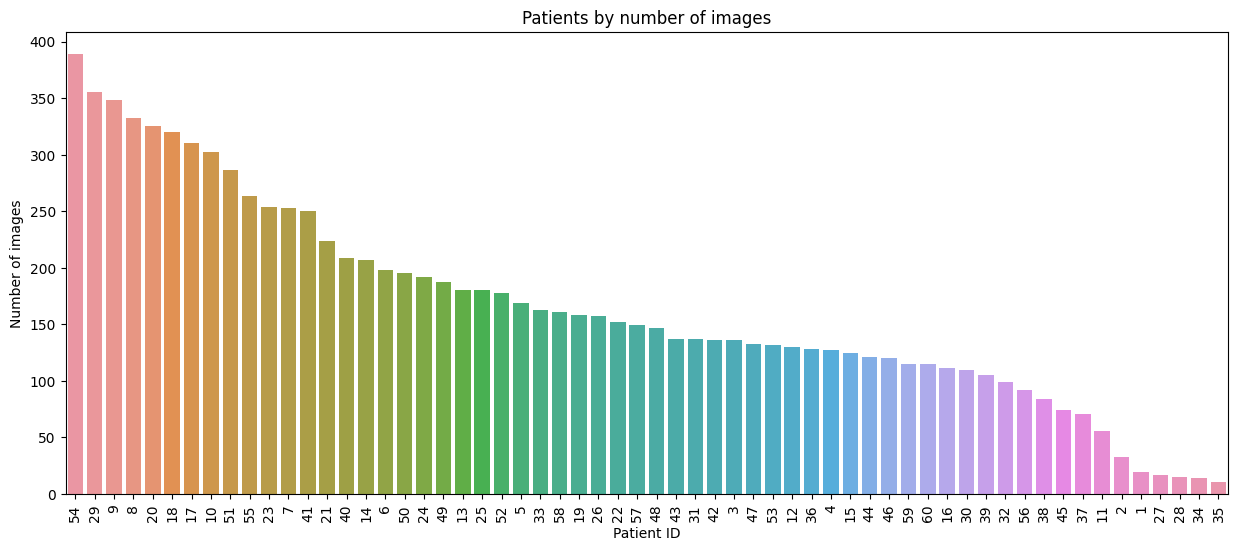

In [ ]:
# Visualize patients by number of images
patient_counts = df_main['patientID'].value_counts()

patient_counts_sorted = patient_counts.sort_values(ascending=False)

plt.figure(figsize=[15, 6])
ax = sns.barplot(x=patient_counts_sorted.index, y=patient_counts_sorted.values, order=patient_counts_sorted.index)
plt.title('Patients by number of images')
plt.xlabel('Patient ID')
plt.ylabel('Number of images')
plt.xticks(rotation='vertical')
plt.show()

#### 3.1.2 - Conclusions for mainData

Because the cellTypeName class "epithelial" in mainData is exclusively cancerous and all other classes cancer-free, mainData is not suitable for training the Task 1 model, as a model trained on images referenced in mainData would likely be biased toward classifying all epithelial cells as cancerous and all other cells as cancer-fee, which in a real world setting could be quite dangerous. Because mainData is the only dataset with cellTypeName labels, given the contstraint of not sourcing outside data, it must be the dataset used to train the model for Task 2 (cell type classification).

Because the distribution of images is skewed towards a smaller subset of patients, test and train sets will be stratified on patientId when splitting, to ensure a balance of images from each patient.

## 3.2 - ExtraData EDA

In [ ]:
# Check for missing values in extraData
print("\nExtra Data Missing Values:")
print(df_extra.isnull().sum())


Extra Data Missing Values:
InstanceID     0
patientID      0
ImageName      0
isCancerous    0
dtype: int64


In [ ]:
print("data_labels_extraData.csv:")
print(df_extra.head())

print("\nClass balance of data_labels_extraData.csv from perspective of task 1:\n")
print("Samples per category:\n")
print(df_extra.isCancerous.value_counts())

data_labels_extraData.csv:
   InstanceID  patientID                 ImageName  isCancerous
0       12681         61  ./patch_images/12681.png            0
1       12682         61  ./patch_images/12682.png            0
2       12683         61  ./patch_images/12683.png            0
3       12684         61  ./patch_images/12684.png            0
4       12685         61  ./patch_images/12685.png            0

Class balance of data_labels_extraData.csv from perspective of task 1:

Samples per category:

0    7394
1    2990
Name: isCancerous, dtype: int64


#### 3.2.1 Observations for extraData

Like mainData, the dataset is imbalanced towards non-cancerous cells. If we assume cellTypeName:isCancerous IS balanced for this dataset (we have no way of knowing at this stage), the implication of the imbalance is that the model will be more accurate at classifying non-cancerous cells, and less accurate when classifying cancerous cells, but not necessarily biased towards either outcome.

As with mainData, extraData has a concentration of images from a smaller number of patients.

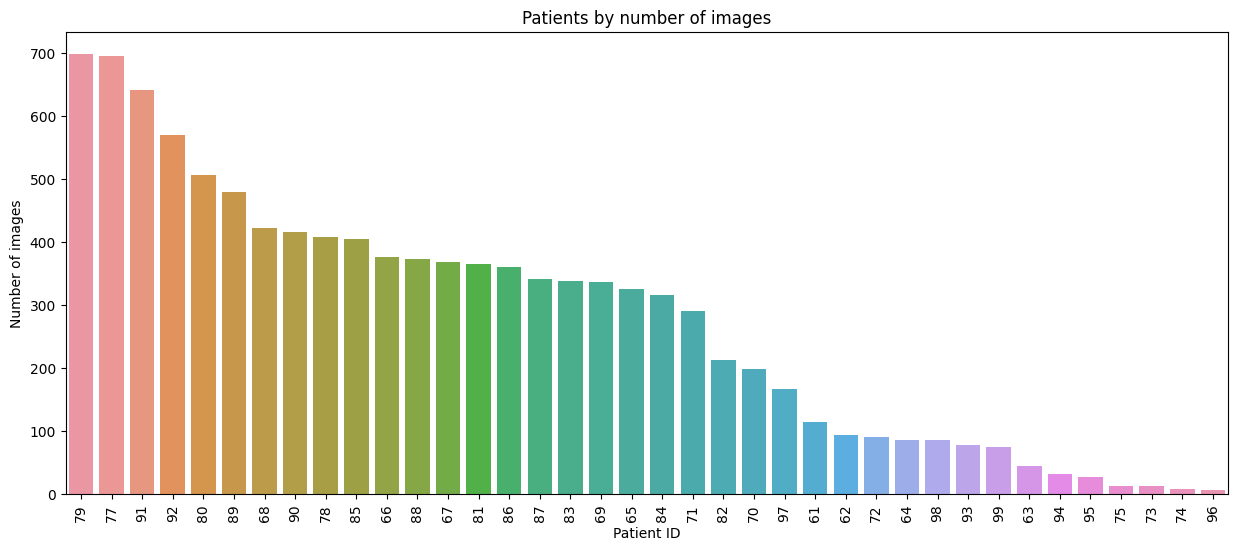

In [ ]:
# Visualize patients by number of images
patient_counts = df_extra['patientID'].value_counts()

patient_counts_sorted = patient_counts.sort_values(ascending=False)

plt.figure(figsize=[15, 6])
ax = sns.barplot(x=patient_counts_sorted.index, y=patient_counts_sorted.values, order=patient_counts_sorted.index)
plt.title('Patients by number of images')
plt.xlabel('Patient ID')
plt.ylabel('Number of images')
plt.xticks(rotation='vertical')
plt.show()

#### 3.2.2 Conclusions for extraData

Because we can't verify the cellTypeName:isCancerous balance for extraData, its not knowable initialy that it will or will not be suitable for Task 1 -  we may run into the same issue mainData has: a single class of cellTypeName being exclusively cancerous or cancer-free. One certaintly however is that extraData is not suitable for Task 2, becuase it has no cellTypeName labels. A possible solution may be to train a model using mainData, and if it has reasonable accuracy, attempt to classify the cellTypeName of samples within extraData. 

## 3.3 - CombinedData EDA

Here we will assess suitability of a concatenated dataset "combinedData" for both Tasks, created by combining extraData and mainData.

In [ ]:
df_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,ImageData,cellTypeName_isCancerous
0,22405,1,./patch_images/22405.png,fibroblast,0,0,"[[[0.9490196, 0.8352941, 0.92941177], [0.93725...",fibroblast_0
1,22406,1,./patch_images/22406.png,fibroblast,0,0,"[[[0.8666667, 0.6862745, 0.827451], [0.8784314...",fibroblast_0
2,22407,1,./patch_images/22407.png,fibroblast,0,0,"[[[0.96862745, 0.9529412, 0.96862745], [0.9725...",fibroblast_0
3,22408,1,./patch_images/22408.png,fibroblast,0,0,"[[[0.9529412, 0.9490196, 0.9490196], [0.952941...",fibroblast_0
4,22409,1,./patch_images/22409.png,fibroblast,0,0,"[[[0.7411765, 0.50980395, 0.7411765], [0.72941...",fibroblast_0


In [ ]:
df_extra.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,./patch_images/12681.png,0
1,12682,61,./patch_images/12682.png,0
2,12683,61,./patch_images/12683.png,0
3,12684,61,./patch_images/12684.png,0
4,12685,61,./patch_images/12685.png,0


In [ ]:
subset_1 = df_main.drop(['InstanceID', 'cellTypeName','cellTypeName_isCancerous', 'cellType', 'ImageData'], axis=1)
subset_2 = df_extra.drop(['InstanceID'], axis=1)

comparison = subset_1.columns == subset_2.columns
assert comparison.all()

combinedData = pd.concat([subset_1, subset_2])

combinedData.set_index('ImageName')

,patientID,isCancerous
ImageName,,
./patch_images/22405.png,1,0
./patch_images/22406.png,1,0
./patch_images/22407.png,1,0
./patch_images/22408.png,1,0
./patch_images/22409.png,1,0
...,...,...
./patch_images/20028.png,99,0
./patch_images/20029.png,99,0
./patch_images/20030.png,99,0


In [ ]:
combinedData.describe()

,patientID,isCancerous
count,20280.000000,20280.000000
mean,55.681065,0.348570
std,28.891837,0.476529
min,1.000000,0.000000
25%,29.000000,0.000000
50%,63.000000,0.000000
75%,81.000000,1.000000
max,99.000000,1.000000


In [ ]:
print("Combined Data:")
print(combinedData.head())

print("\nClass balance of Combined Data from perspective of task 1:\n")
print("Samples per category:\n")
print(combinedData.isCancerous.value_counts())

Combined Data:
   patientID                 ImageName  isCancerous
0          1  ./patch_images/22405.png            0
1          1  ./patch_images/22406.png            0
2          1  ./patch_images/22407.png            0
3          1  ./patch_images/22408.png            0
4          1  ./patch_images/22409.png            0

Class balance of Combined Data from perspective of task 1:

Samples per category:

0    13211
1     7069
Name: isCancerous, dtype: int64


#### 3.3.1 - Observations for extraData

> - The combined data consists of a total of 20,280 samples.
> - The 'isCancerous' feature shows a class imbalance, with 13,211 non-cancerous (0) samples and 7,069 cancerous (1) samples.
> - The majority class is non-cancerous, with nearly twice as many samples as the minority class.

### 3.3.2 - Conclusions for combinedData

Just like extraData, in our combinedData we can't verify the cellTypeName:isCancerous balance.

# 4 - Hypotheses

Hypothetical process for using extraData to improve Task 1: 

1.   Preliminary data splitting: split train-test sets for each of the two datasets, stratifying on patientId. 

2.   Train the Task 2 model (cellTypeName classifier) on the mainData image dataset.
3.   Assuming Task 2 model is perfomant, attempt to classify the cellTypeName of images in extraData.
4.   Train the Task 1 model (isCancerous classifier) on the now-classified extraData image dataset if extraData proves to be balanced. 
5.   If extraData is not balanced and therefore not suitable to Task 1 model training, now that the cellTypeName might be accurately predicted for extraData, investigate if it is possible to create a balanced dataset out of both datasets. Note this step may not be possible, depending on outcome of step 2 (predicition accuracy and balance)

The above hypothesis will be tested and validated once both baseline models are set up. 

In support of this, we will establish the Task 2 model first.


# 5 - Task 2: Classify images according to cell type

The goal for Task 2 is to train a model that is able to classify images according to cell type (multi-class classification task).

A baseline traditional neural network will be set up and trained on images referenced in mainData. The text component of the dataset has already been loaded as `df_main`. Image filenames are specified in mainData ready for batch loading in the next steps.

##5.1 Performance metrics

Performance metrics chosen for Task 2: F1-Score and Categorical Accuracy.

The aim Task 2 is to classify images according to cell type. In the mainData, we have four types of cells: 'fibroblast', 'inflammatory', 'epithelial', and 'others'. So this is a multi-class classification problem.

The distribution of these cell types is not balanced - epithelial: 4079, inflammatory: 2543, fibroblast: 1888, others: 1386.

An imbalanced dataset could result in a model that is biased towards the majority class, hence having a high accuracy but poor performance on minority classes. This could affect the performance of our model, making accuracy alone not the best metric for evaluation.

F1-score is a better metric in such this case because it considers both the precision (how many of the cells that we identified as a particular type were actually of that type) and recall (how many of the cells of a particular type did we correctly identify). This is important in medical diagnostics where both false positives and false negatives could have serious implications.

By using F1-score, we are aiming for a balance between precision and recall, and ensuring that our model performs well across all cell types, not just the majority class. This makes F1-score a good choice for evaluating our multi-class classification problem.

## 5.2 Split dataset

mainData is split into train, test and validation sets 60 / 20 / 20, stratifying on patientID. A fixed random seed is used for reproducibility of results.

In [ ]:
train_mainData, test_mainData = train_test_split(df_main, stratify=df_main["patientID"], test_size=0.2, random_state=RANDOM_SEED)
train_mainData, val_mainData = train_test_split(train_mainData, stratify=train_mainData["patientID"], test_size=0.25, random_state=RANDOM_SEED)
print(f"Train data : {train_mainData.shape[0]}, Val Data: {val_mainData.shape[0]}, Test Data: {test_mainData.shape[0]}")

Train data : 5937, Val Data: 1979, Test Data: 1980


##5.3 Baseline NN model for Task 2

In line with our problem domain, 4 output classes are specified for the model, and input dimensions set to 27 x 27 to match the size of the cell images.

Hidden layer dimensions are set to 256 as  a baseline.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________
None


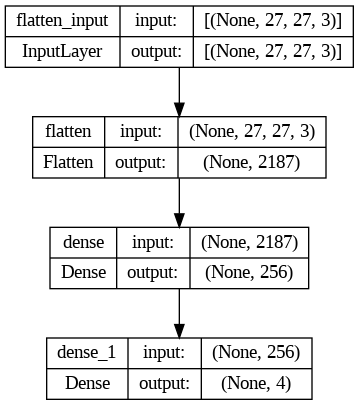

In [ ]:
# Set model parameters
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

# Create model
model_task2_baseline = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation=tf.keras.activations.softmax)
])

print(model_task2_baseline.summary())

tf.keras.utils.plot_model(model_task2_baseline, show_shapes=True)

The model is now compiled with some final settings. Justification for each setting:

`optimizer`: Stochastic Gradient Descent (SGD) will be used initally as a baseline.

`loss`: CategoricalCrossEntropy is used as it matches our problem: multi-class classification with mutually exclusive classes.

`metrics`: f1 will be used alongside categorical accuracy becuse for reasons outlined in section 5.1

In [ ]:
model_task2_baseline.compile(
    optimizer='SGD',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    # metrics=['AUC', 'categorical_accuracy'])
    # metrics=[f1_m, 'categorical_accuracy'])
    metrics=[f1_m, 'categorical_accuracy', precision_m, recall_m])


Images are batch loaded with Keras ImageDataGenerator. To speed up training, pixels are rescaled with ImageDataGenerator's built in rescale argument.

In [ ]:
train_imgData = ImageDataGenerator(rescale=1./255, data_format='channels_last')

train_gen = train_imgData.flow_from_dataframe(
        dataframe=train_mainData,
        directory='./',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=64,
        class_mode='categorical')

val_imgData = ImageDataGenerator(rescale=1./255, data_format='channels_last')

val_gen = val_imgData.flow_from_dataframe(
        dataframe=val_mainData,
        directory='./',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=64,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


The baseline model will now be trained. A range of epochs were tested ranging from 35 to 70. The curve fit at 50 and 60 epochs was deemed "best fit", as train and val curves stabilised and converged at around 0.8 loss, with loss decreasing as epochs increased. So the default epoch of 50 was used for the baseline model.


In [ ]:
history = model_task2_baseline.fit(train_gen, validation_data=val_gen, epochs=50, verbose=0)

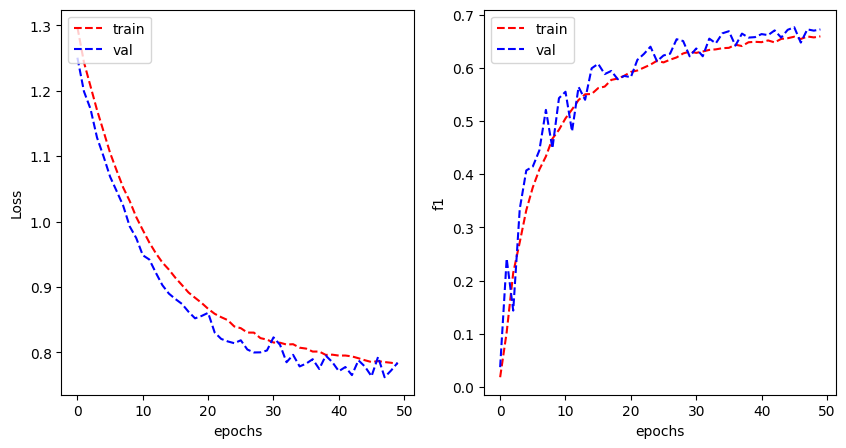

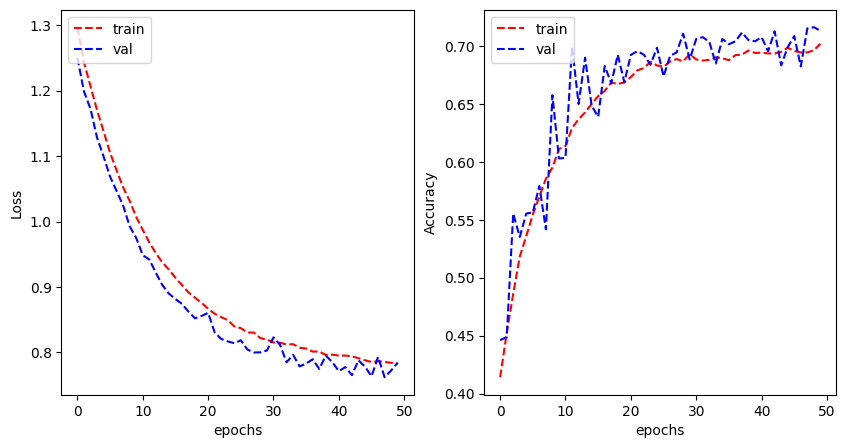

In [ ]:
# plot_learning_curve(history.history['loss'], history.history['val_loss'], 
#                     history.history['auc'], history.history['val_auc'], 
#                     metric_name='AUC')

plot_learning_curve(history.history['loss'], history.history['val_loss'], history.history['f1_m'], history.history['val_f1_m'], metric_name='f1')
plot_learning_curve(history.history['loss'], history.history['val_loss'], history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], metric_name='Accuracy')

Loss decreased and stabilised as epochs increased, and train and val curves eventually converge towards the end of training, implying the model had decent fit. Based on the fit of the two curves, the model is neither over or under-fitting right out of the box.

In [ ]:
test_imgData = ImageDataGenerator(rescale=1./255, data_format='channels_last')

test_gen = test_imgData.flow_from_dataframe(
        dataframe=test_mainData,
        directory='./',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=64,
        class_mode='categorical')

model_task2_baseline.evaluate(test_gen)

Found 1980 validated image filenames belonging to 4 classes.
31/31 [==============================] - 1s 37ms/step - loss: 0.7997 - f1_m: 0.6631 - categorical_accuracy: 0.6869 - precision_m: 0.7834 - recall_m: 0.5762


[0.7997046113014221,
 0.6631132960319519,
 0.6868686676025391,
 0.78341144323349,
 0.5762432813644409]

We can see f1 and accurracy both stabilised just under 0.7 on the validation set, with f1 slightly lower. This aligns with what we knew about the class imbalance of mainData; the f1 being slighly lower is likely representative of classes with less samples having lower accuracy, potentially by nature of having less training samples. We check this by evaluating classification accuracy for each individual class.

A separate dataframe and ImgaeDataGenerator will be set up for each sub-class of cellTypeName and assessed standalone.

## 5.4 Iterative improvements to Task 2 baseline model

### 5.4.1 - Applying regularisation

Next we will regulartization on our baseline model and evaluate the results.

[WHY DID WE DO THIS]

In [ ]:
reg_lambda = 0.001

reg_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation = 'sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation=tf.keras.activations.softmax, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
reg_model.compile(
    optimizer = 'SGD',
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics = [f1_m, precision_m, recall_m, 'categorical_accuracy']
)

In [ ]:
reg_history = reg_model.fit(train_gen, validation_data = val_gen, epochs = 50, verbose = 0)

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


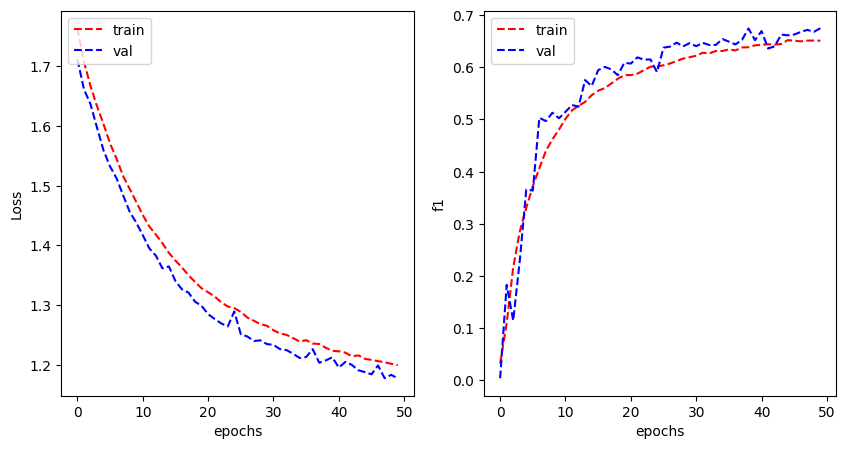

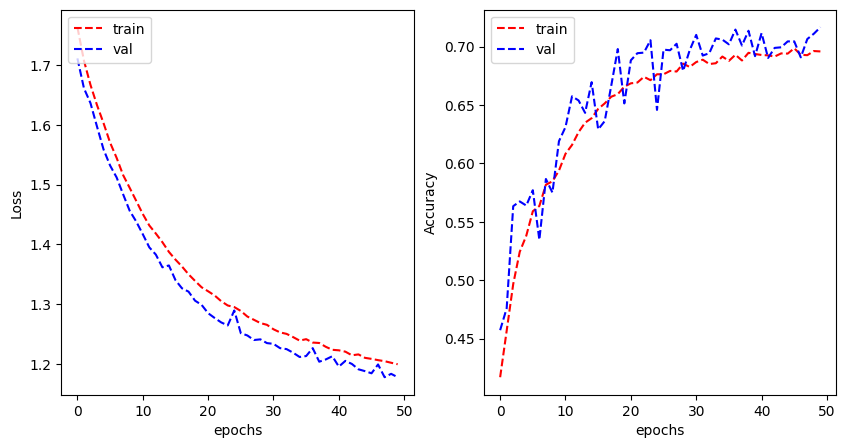

In [ ]:
plot_learning_curve(reg_history.history['loss'], reg_history.history['val_loss'], reg_history.history['f1_m'], reg_history.history['val_f1_m'], metric_name='f1')
plot_learning_curve(reg_history.history['loss'], reg_history.history['val_loss'], reg_history.history['categorical_accuracy'], reg_history.history['val_categorical_accuracy'], metric_name='Accuracy')

In [ ]:
reg_model.evaluate(train_gen)
reg_model.evaluate(val_gen)

31/31 [==============================] - 1s 29ms/step - loss: 1.1780 - f1_m: 0.6749 - precision_m: 0.8171 - recall_m: 0.5760 - categorical_accuracy: 0.7165


[1.1780099868774414,
 0.674942672252655,
 0.8170713782310486,
 0.5760063529014587,
 0.7165234684944153]

> Observations

The regularized model shows an improvement in performance. The training accuracy increased to 70.20% and the validation accuracy increased to 71.35%. The F1 score also increased to about 0.67 on the training set and 0.68 on the validation set. This shows that the regularization helped to make the model more generalized and improved its performance on the validation set. However, the loss has increased compared to the baseline model, indicating that the model may be underfitting the training data.

> Conclusions

We will trying more complex models, adding a hidden layer.

### 5.4.2 - Adding more layers - 1

In [ ]:
layer1_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation = 'sigmoid'),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM*(1/4), activation = 'relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation=tf.keras.activations.softmax)
])

In [ ]:
layer1_model.compile(
    optimizer = 'SGD',
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics = [f1_m, precision_m, recall_m, 'categorical_accuracy']
)

In [ ]:
layer1_history = layer1_model.fit(train_gen, validation_data = val_gen, epochs = 50, verbose = 0)

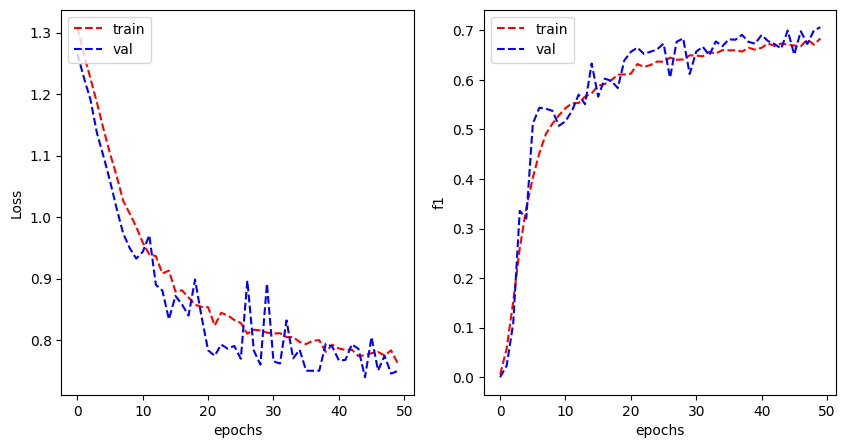

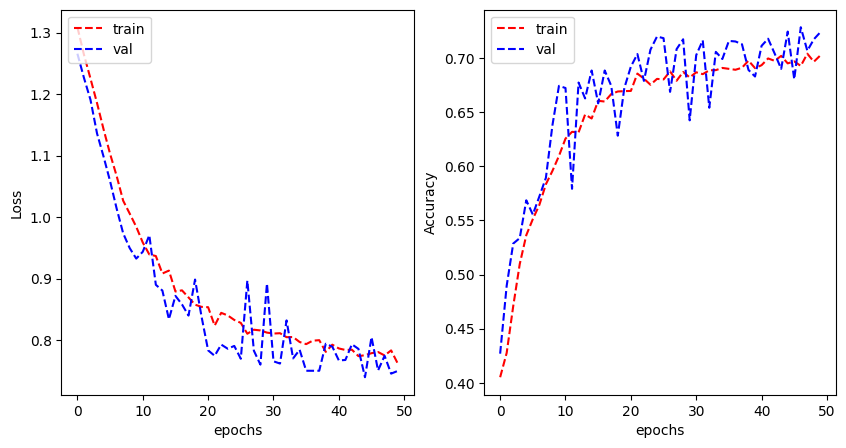

In [ ]:
plot_learning_curve(layer1_history.history['loss'], layer1_history.history['val_loss'], layer1_history.history['f1_m'], layer1_history.history['val_f1_m'], metric_name='f1')
plot_learning_curve(layer1_history.history['loss'], layer1_history.history['val_loss'], layer1_history.history['categorical_accuracy'], layer1_history.history['val_categorical_accuracy'], metric_name='Accuracy')

In [ ]:
layer1_model.evaluate(train_gen)
layer1_model.evaluate(val_gen)

31/31 [==============================] - 1s 27ms/step - loss: 0.7499 - f1_m: 0.7065 - precision_m: 0.8083 - recall_m: 0.6288 - categorical_accuracy: 0.7236


[0.7498906850814819,
 0.7064625024795532,
 0.8083198070526123,
 0.6288101673126221,
 0.7235977649688721]

### 5.4.3 - Adding more layers - 2

We will intoduce more complexity by adding more dense layers while also applying L2 regularization and using different activation functions ('sigmoid' and 'relu').

In [ ]:
layer2_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation = 'sigmoid'),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM*(3/4), activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM*(1/4), activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation=tf.keras.activations.softmax)
])

In [ ]:
layer2_model.compile(
    optimizer = 'SGD',
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics = [f1_m, precision_m, recall_m, 'categorical_accuracy']
)

In [ ]:
layer2_history = layer2_model.fit(train_gen, validation_data = val_gen, epochs = 50, verbose = 0)

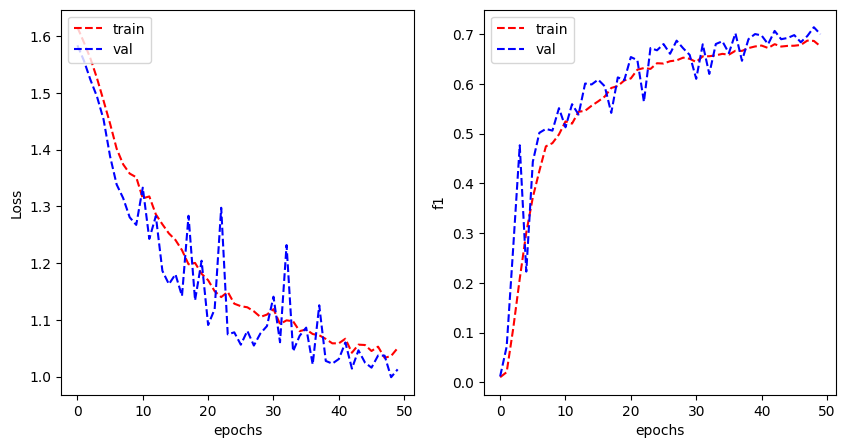

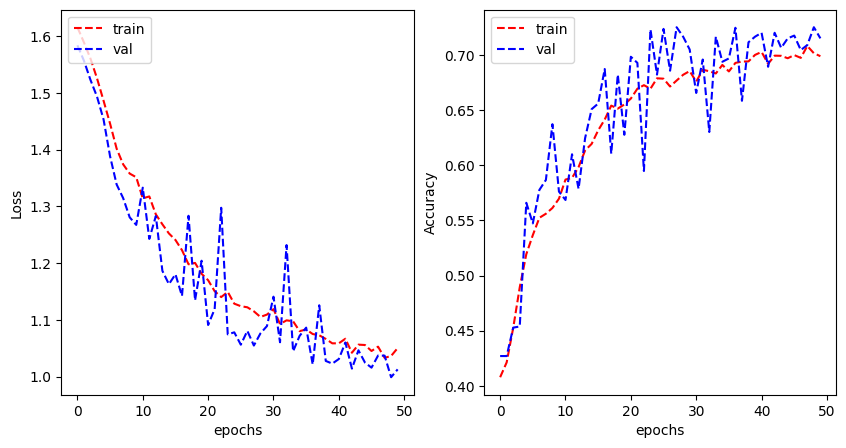

In [ ]:
plot_learning_curve(layer2_history.history['loss'], layer2_history.history['val_loss'], layer2_history.history['f1_m'], layer2_history.history['val_f1_m'], metric_name='f1')
plot_learning_curve(layer2_history.history['loss'], layer2_history.history['val_loss'], layer2_history.history['categorical_accuracy'], layer2_history.history['val_categorical_accuracy'], metric_name='Accuracy')

In [ ]:
layer2_model.evaluate(train_gen)
layer2_model.evaluate(val_gen)

31/31 [==============================] - 1s 27ms/step - loss: 1.0129 - f1_m: 0.6992 - precision_m: 0.7799 - recall_m: 0.6345 - categorical_accuracy: 0.7150


[1.0128852128982544,
 0.6992051005363464,
 0.7799455523490906,
 0.6345168352127075,
 0.7150076031684875]

> Observations

> - Training Set: The training categorical accuracy of the model has improved to 72.16% and the F1 score has increased to 0.6952. Precision and recall have also improved, now being 0.7986 and 0.6168 respectively. This indicates that the model is performing better on the training set compared to previous models. The increase in F1 score, indicates that the model's balance between correctly identifying positive cases and not marking negative cases as positive has improved.

> - Validation Set: The validation categorical accuracy has also improved to 72.97% and the F1 score on the validation set has increased to 0.7068. Precision and recall on the validation set have also improved to 0.8081 and 0.6296 respectively. This demonstrates that the model is generalizing well and its performance on unseen data has improved.

> - The loss value is higher than in the previous models. 

> Conclusions

> - Adding more layers and regularization to the model seems to have improved its performance only by a little on both the training and validation sets. It demonstrates that the model's complexity is better capturing the patterns in the data

> - We will consider increasing epochs.

### 5.4.4 - Increasing Epochs

In [ ]:
layer3_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation = 'sigmoid'),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM*(3/4), activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM*(1/4), activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation=tf.keras.activations.softmax)
])

In [ ]:
layer3_model.compile(
    optimizer = 'SGD',
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics = [f1_m, precision_m, recall_m, 'categorical_accuracy']
)

In [ ]:
layer3_history = layer3_model.fit(train_gen, validation_data = val_gen, epochs = 125, verbose = 0)

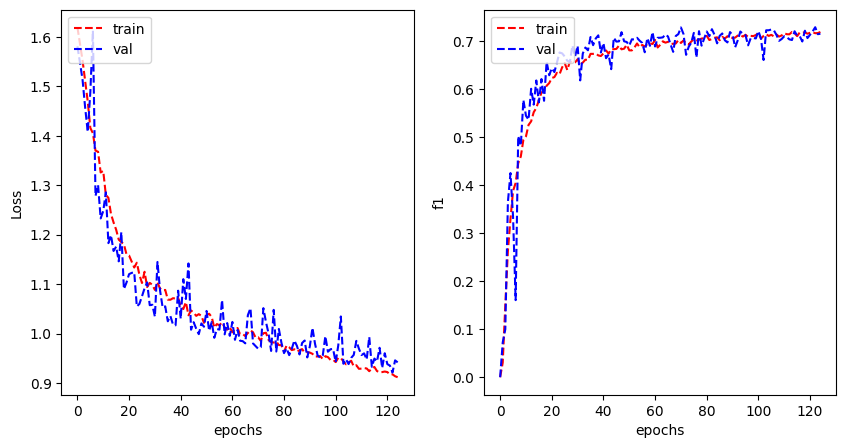

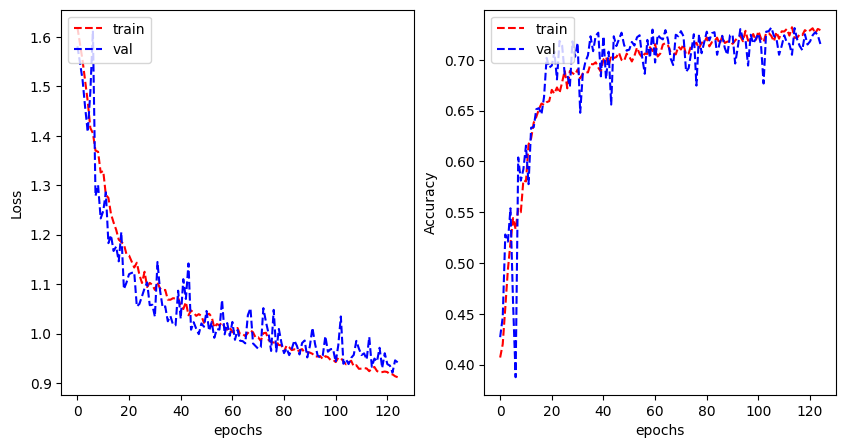

In [ ]:
plot_learning_curve(layer3_history.history['loss'], layer3_history.history['val_loss'], layer3_history.history['f1_m'], layer3_history.history['val_f1_m'], metric_name='f1')
plot_learning_curve(layer3_history.history['loss'], layer3_history.history['val_loss'], layer3_history.history['categorical_accuracy'], layer3_history.history['val_categorical_accuracy'], metric_name='Accuracy')

In [ ]:
layer3_model.evaluate(test_gen)

31/31 [==============================] - 1s 27ms/step - loss: 0.9666 - f1_m: 0.7020 - precision_m: 0.7594 - recall_m: 0.6536 - categorical_accuracy: 0.7015


[0.9665622115135193,
 0.7019977569580078,
 0.7594097852706909,
 0.6535618305206299,
 0.7015151381492615]

> Conclusions

> - Adding more layers and increasing epochs seems to have improved its performance only by a little. It demonstrates that the model's complexity is better capturing the patterns in the data

> - We will consider tryng out a more complex model such as CNN and its modifications to see if we will get better improvements.

In [ ]:
classes = {'fibroblast' : 0, 'inflammatory' : 1, 'others' : 2, 'epithelial' : 3} 

predict = model_task2_baseline.predict(test_gen, steps=len(test_mainData))



  31/1980 [..............................] - ETA: 53s

1980/1980 [==============================] - 1s 587us/step


In [ ]:
test_mainData_fibroblast = test_mainData.loc[test_mainData['cellTypeName'] == 'fibroblast']

test_gen_fibroblast = ImageDataGenerator(rescale=1./255, data_format='channels_last').flow_from_dataframe(
        dataframe=test_mainData_fibroblast,
        directory='./',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=1,
        class_mode='categorical')

predict = model_task2_baseline.evaluate(test_gen_fibroblast, steps=len(test_mainData_fibroblast))

Found 375 validated image filenames belonging to 1 classes.
375/375 [==============================] - 1s 4ms/step - loss: 7.7263 - f1_m: 0.7147 - categorical_accuracy: 0.0960 - precision_m: 0.7147 - recall_m: 0.7147


In [ ]:
test_mainData_inflammatory = test_mainData.loc[test_mainData['cellTypeName'] == 'inflammatory']

test_gen_inflammatory = ImageDataGenerator(rescale=1./255, data_format='channels_last').flow_from_dataframe(
        dataframe=test_mainData_inflammatory,
        directory='./',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=64,
        class_mode='categorical')

predict = model_task2_baseline.evaluate(test_gen_inflammatory)

Found 498 validated image filenames belonging to 1 classes.
8/8 [==============================] - 0s 30ms/step - loss: 7.9001 - f1_m: 0.7729 - categorical_accuracy: 0.1124 - precision_m: 1.0000 - recall_m: 0.6311


In [ ]:
test_mainData_others = test_mainData.loc[test_mainData['cellTypeName'] == 'others']

test_gen_others = ImageDataGenerator(rescale=1./255, data_format='channels_last').flow_from_dataframe(
        dataframe=test_mainData_others,
        directory='./',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=1,
        class_mode='categorical')

predict = model_task2_baseline.evaluate(test_gen_others, steps=len(test_mainData_others))

Found 294 validated image filenames belonging to 1 classes.
294/294 [==============================] - 1s 3ms/step - loss: 8.0493 - f1_m: 0.6190 - categorical_accuracy: 0.1361 - precision_m: 0.6190 - recall_m: 0.6190


In [ ]:
test_mainData_epithelial = test_mainData.loc[test_mainData['cellTypeName'] == 'epithelial']

test_gen_epithelial = ImageDataGenerator(rescale=1./255, data_format='channels_last').flow_from_dataframe(
        dataframe=test_mainData_epithelial,
        directory='./',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=1,
        class_mode='categorical')

predict = model_task2_baseline.evaluate(test_gen_epithelial, steps=len(test_mainData_epithelial))

Found 813 validated image filenames belonging to 1 classes.
813/813 [==============================] - 3s 4ms/step - loss: 9.8449 - f1_m: 0.8499 - categorical_accuracy: 0.8475 - precision_m: 0.8499 - recall_m: 0.8499


### 5.4.5 - CNN as base model type
A Convolutional Neural Network (CNN) will be setup up as the base of the improved model.


In [ ]:
reg_lambda = 0.001

# Create model
model_task2_cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_DIM),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
        
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

# model_task2_cnn = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=INPUT_DIM),
#     tf.keras.layers.MaxPool2D(),
#     tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
#     tf.keras.layers.MaxPool2D(),
#     tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
#     tf.keras.layers.Dense(OUTPUT_CLASSES, activation=tf.keras.activations.softmax)
# ])

# model_task2_cnn = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=INPUT_DIM),
#     tf.keras.layers.MaxPool2D(pool_size=(1,1)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
#     tf.keras.layers.Dense(OUTPUT_CLASSES, activation=tf.keras.activations.softmax)
# ])

# print(model_task2_cnn.summary())

# tf.keras.utils.plot_model(model_task2_cnn, show_shapes=True)


In [ ]:
sgd = tf.keras.optimizers.SGD(momentum=0.9, nesterov=True)

model_task2_cnn.compile(
    optimizer=sgd,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[f1_m, 'categorical_accuracy'])

history_cnn = model_task2_cnn.fit(train_gen, 
                                    validation_data = val_gen, 
                                    epochs=130, verbose=0)

In [ ]:
model_task2_cnn.evaluate(test_gen)

31/31 [==============================] - 1s 34ms/step - loss: 1.6786 - f1_m: 0.6983 - categorical_accuracy: 0.6990


[1.6786245107650757, 0.6982969641685486, 0.6989899277687073]

In [ ]:
model_task2_cnn.evaluate(val_gen)


31/31 [==============================] - 1s 34ms/step - loss: 1.7666 - f1_m: 0.6887 - categorical_accuracy: 0.6882


[1.7665525674819946, 0.6886796355247498, 0.6882264018058777]

### 5.4.6 - VGG as base model type



In [ ]:
VGG_model = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation="sigmoid"),
])
VGG_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 27, 27, 32)        896       
                                                                 
 conv2d_4 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                  

In [ ]:
VGG_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[f1_m, precision_m, recall_m, 'categorical_accuracy'])

In [ ]:
VGG_history = VGG_model.fit(train_gen, validation_data = val_gen, epochs = 30, verbose = 0)

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


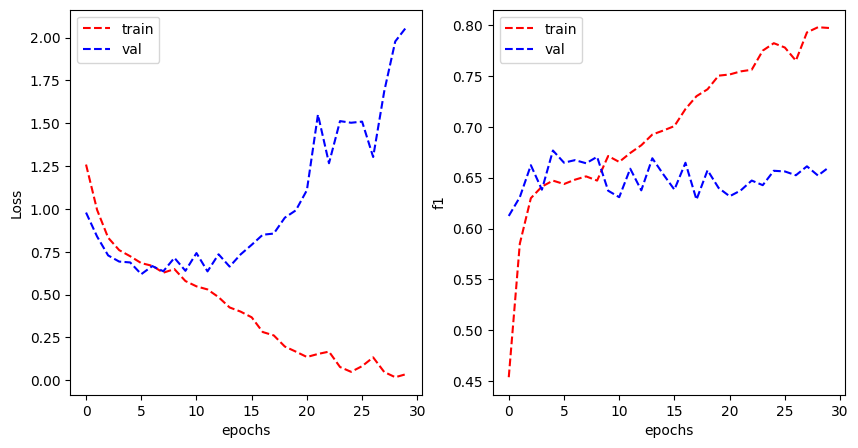

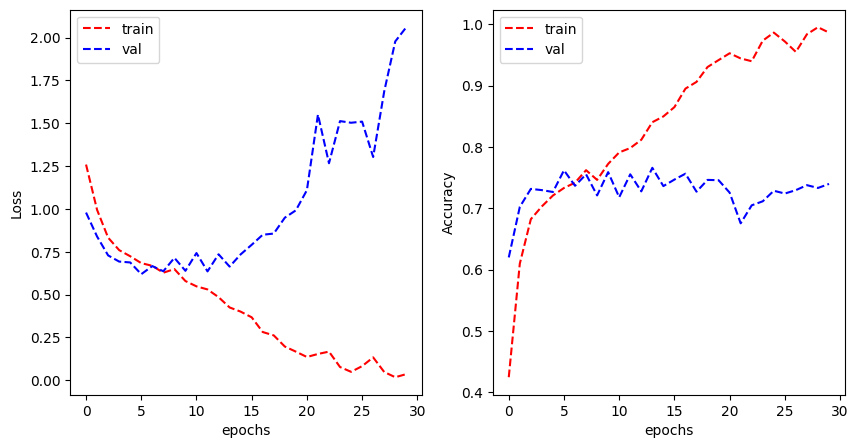

In [ ]:
plot_learning_curve(VGG_history.history['loss'], VGG_history.history['val_loss'], VGG_history.history['f1_m'], VGG_history.history['val_f1_m'], metric_name='f1')
plot_learning_curve(VGG_history.history['loss'], VGG_history.history['val_loss'], VGG_history.history['categorical_accuracy'], VGG_history.history['val_categorical_accuracy'], metric_name='Accuracy')

In [ ]:
VGG_model.evaluate(train_gen)
VGG_model.evaluate(val_gen)

31/31 [==============================] - 3s 93ms/step - loss: 2.0611 - f1_m: 0.6601 - precision_m: 0.5396 - recall_m: 0.8510 - categorical_accuracy: 0.7398


[2.0611143112182617,
 0.6601411700248718,
 0.5396284461021423,
 0.8509687781333923,
 0.7397675514221191]

> Observations

> - Training Set: The model has very high accuracy (97.27%) and a low loss (0.0814) on the training data, suggesting it's performing very well there. The F1 score, precision, and recall are also relatively high.

> - Validation Set: When applied to the validation data, the model's performance drops significantly. The accuracy decreases to 73.93%, and the loss increases to 1.6184. The F1 score, precision, and recall are also lower compared to the training data. This drop in performance is a clear indicator of overfitting.

> Conclusions

We will try adding regularization

#### - 5.4.6.1 Adding Regularization

In [ ]:
reg_lambda = 0.001

VGG_model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
VGG_model2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[f1_m, precision_m, recall_m, 'categorical_accuracy'])

In [ ]:
VGG_history2 = VGG_model2.fit(train_gen, validation_data = val_gen, epochs = 30, verbose = 0)

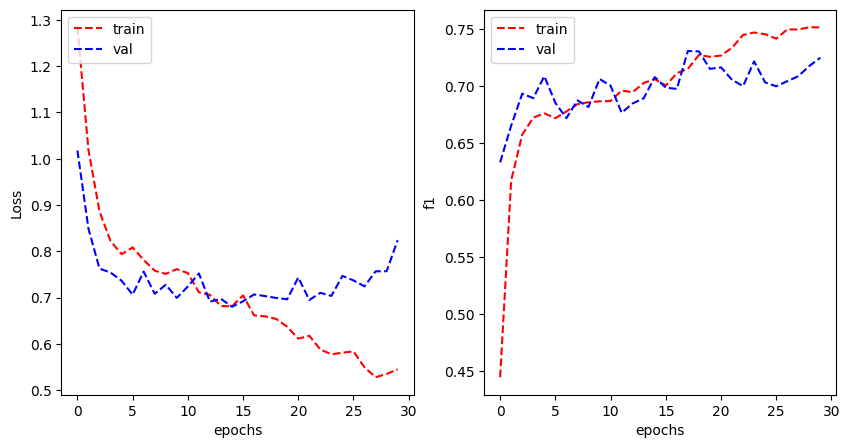

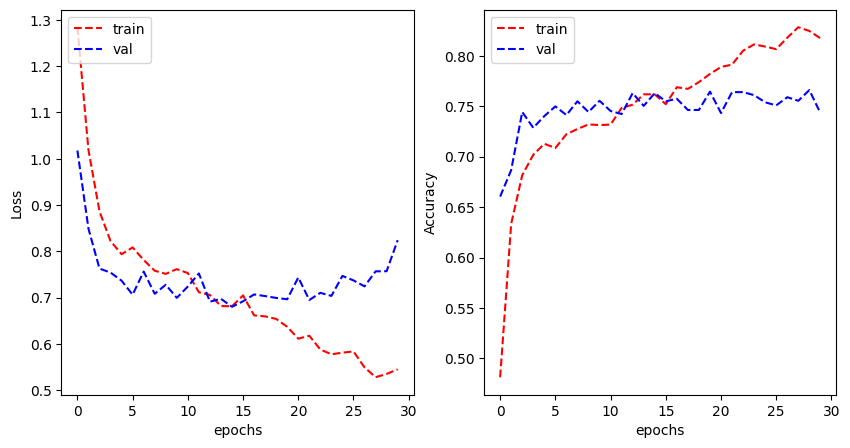

In [ ]:
plot_learning_curve(VGG_history2.history['loss'], VGG_history2.history['val_loss'], VGG_history2.history['f1_m'], VGG_history2.history['val_f1_m'], metric_name='f1')
plot_learning_curve(VGG_history2.history['loss'], VGG_history2.history['val_loss'], VGG_history2.history['categorical_accuracy'], VGG_history2.history['val_categorical_accuracy'], metric_name='Accuracy')

In [ ]:
VGG_model2.evaluate(train_gen)
VGG_model2.evaluate(val_gen)

31/31 [==============================] - 2s 63ms/step - loss: 0.8240 - f1_m: 0.7254 - precision_m: 0.6513 - recall_m: 0.8196 - categorical_accuracy: 0.7433


[0.8239612579345703,
 0.7253552675247192,
 0.6513389348983765,
 0.8196333646774292,
 0.7433046698570251]

> Observations

> - Training Set: The model's performance on the training data is still high but lower than before (accuracy decreased from 97.27% to 81.19%), which is a good sign. It means the model is not learning the training data too well. The loss has increased from 0.0814 to 0.5648, which is expected when using regularization as it adds a penalty to the loss function.

> - Validation Set: The model's performance on the validation data has improved. The accuracy has slightly increased from 73.93% to 76.05%, and the loss has decreased from 1.6184 to 0.7301. These changes suggest that the model is generalizing better and not overfitting as much. However, there's still a noticeable gap between the training and validation metrics, suggesting that the model might still be overfitting a bit.

> Conclusions

> - We will attempt to reduce the number of neurons to see if we can stop it from overfitting.



#### 5.4.6.2 - Increasing regularization/dropout & reducing Layers

In [ ]:
reg_lambda = 0.01

VGG_model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
VGG_model3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[f1_m, precision_m, recall_m, 'categorical_accuracy'])

In [ ]:
VGG_history3 = VGG_model3.fit(train_gen, validation_data = val_gen, epochs = 30, verbose = 0)

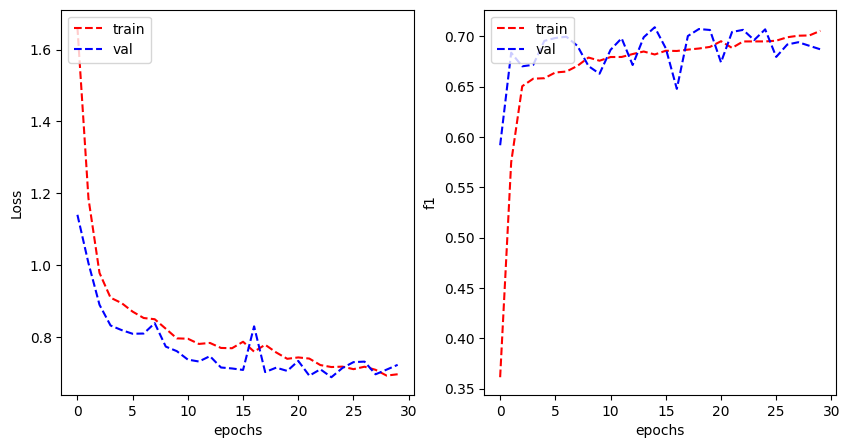

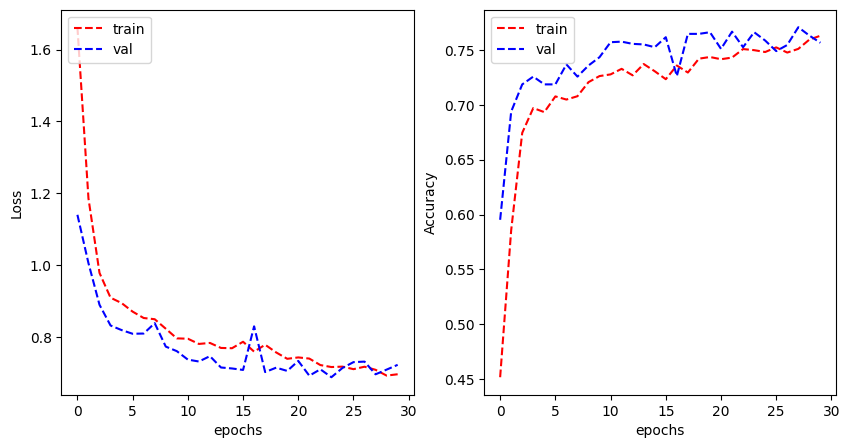

In [ ]:
plot_learning_curve(VGG_history3.history['loss'], VGG_history3.history['val_loss'], VGG_history3.history['f1_m'], VGG_history3.history['val_f1_m'], metric_name='f1')
plot_learning_curve(VGG_history3.history['loss'], VGG_history3.history['val_loss'], VGG_history3.history['categorical_accuracy'], VGG_history3.history['val_categorical_accuracy'], metric_name='Accuracy')

In [ ]:
VGG_model3.evaluate(train_gen)
VGG_model3.evaluate(val_gen)

31/31 [==============================] - 2s 61ms/step - loss: 0.7222 - f1_m: 0.6872 - precision_m: 0.5720 - recall_m: 0.8616 - categorical_accuracy: 0.7564


[0.7222424745559692,
 0.6871824860572815,
 0.5719966888427734,
 0.8615961670875549,
 0.756442666053772]

> Observations

> - After increasing regularization and dropout, and reducing the number of layers to the model.The results show that the model's performance has improved slightly, compared to the previous model. The validation categorical accuracy has risen from 0.7605 to 0.7676 and F1 score from 0.7299 to 0.7067. However, the precision has dropped slightly from 0.6944 to 0.6071. This indicates that while the model is becoming more accurate overall, it's producing more false positives. The regularization and dropout seem to have improved the model's ability to generalize but at the cost of precision

> -  There might be a small degree of overfitting. However, the difference between the training and validation metrics is not very large, so the model seems to generalize reasonably well to unseen data.

#### 5.4.6.3 - Data augmentation

We will apply augmentation to the images before they are trained.

we won't apply data augmentation to the validation generator, because we want to validate the model on real-world data without any artificial alterations.

In [ ]:
train_imgData = ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last',
    rotation_range=20,      # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2, # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,   # randomly flip images
    zoom_range=0.2          # Randomly zoom image 
)

train_gen = train_imgData.flow_from_dataframe(
        dataframe=train_mainData,
        directory='./',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=64,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.


In [ ]:
reg_lambda = 0.01

VGG_model_aug = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
VGG_model_aug.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[f1_m, precision_m, recall_m, 'categorical_accuracy'])

In [ ]:
VGG_history_aug = VGG_model_aug.fit(train_gen, validation_data = val_gen, epochs = 30, verbose = 0)

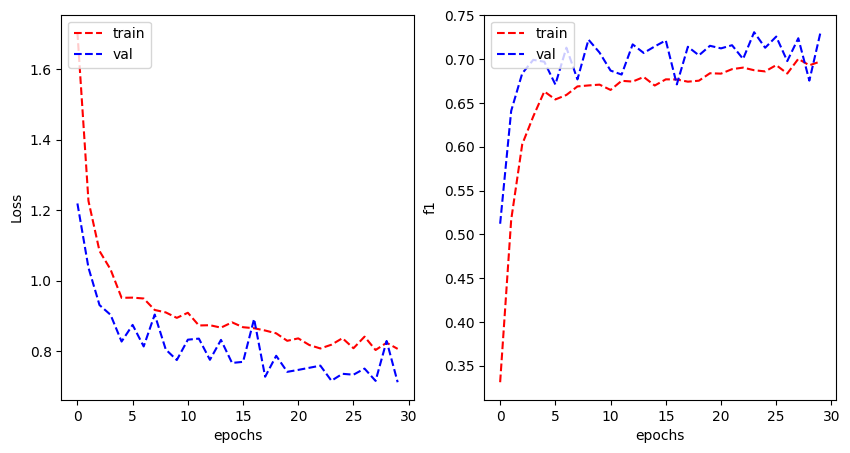

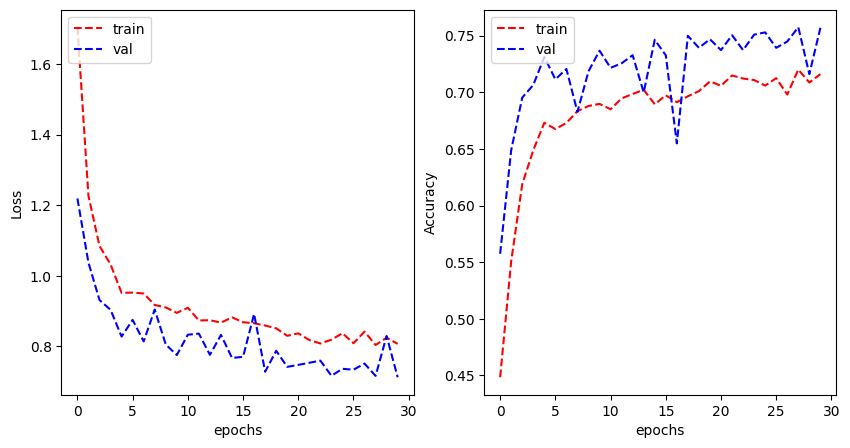

In [ ]:
plot_learning_curve(VGG_history_aug.history['loss'], VGG_history_aug.history['val_loss'], VGG_history_aug.history['f1_m'], VGG_history_aug.history['val_f1_m'], metric_name='f1')
plot_learning_curve(VGG_history_aug.history['loss'], VGG_history_aug.history['val_loss'], VGG_history_aug.history['categorical_accuracy'], VGG_history_aug.history['val_categorical_accuracy'], metric_name='Accuracy')

In [ ]:
VGG_model_aug.evaluate(train_gen)
VGG_model_aug.evaluate(val_gen)

31/31 [==============================] - 2s 60ms/step - loss: 0.7123 - f1_m: 0.7304 - precision_m: 0.6696 - recall_m: 0.8042 - categorical_accuracy: 0.7569


[0.7123335003852844,
 0.7303882241249084,
 0.669638454914093,
 0.8042219281196594,
 0.756947934627533]

> Observations

The results from the new data augmentation approach don't seem to be an improvement over the previous model. It seems like it is underfitting, though the evaluation results look good the curve suggests otherwise.

## 5.5 Final performance evaluation

In [ ]:
test_mainData['cellTypeName'] = test_mainData['cellTypeName'].astype('str')

test_imgData = ImageDataGenerator(rescale=1./255, data_format='channels_last')

test_gen = test_imgData.flow_from_dataframe(
        dataframe = test_mainData,
        directory = './',
        x_col = "ImageName",
        y_col = "cellTypeName",
        target_size = (27, 27),
        batch_size=64,
        class_mode = 'categorical')

Found 1980 validated image filenames belonging to 4 classes.


In [ ]:
scores = VGG_model_aug.evaluate(test_gen)
print("Accuracy: %.2f%%" % (scores[1]*100))

31/31 [==============================] - 2s 61ms/step - loss: 0.7418 - f1_m: 0.7208 - precision_m: 0.6612 - recall_m: 0.7933 - categorical_accuracy: 0.7379
Accuracy: 72.08%


In [ ]:
scores = VGG_model2.evaluate(test_gen)
print("Accuracy: %.2f%%" % (scores[1]*100))

31/31 [==============================] - 2s 62ms/step - loss: 0.8392 - f1_m: 0.7084 - precision_m: 0.6354 - recall_m: 0.8018 - categorical_accuracy: 0.7303
Accuracy: 70.84%


In [ ]:
scores = VGG_model3.evaluate(test_gen)
print("Accuracy: %.2f%%" % (scores[1]*100))

31/31 [==============================] - 2s 63ms/step - loss: 0.7435 - f1_m: 0.6764 - precision_m: 0.5623 - recall_m: 0.8500 - categorical_accuracy: 0.7333
Accuracy: 67.64%


# 6 - Enhancing extraData with predicted cellTypeName labels

Using the procedure described in section 4 (Hypotheses) we will now predict cellTypeName labels for extraData, in an attempt to validate if it is suitable balanced to use as a training set for Task 1.

The most performant model from the prior steps will be used, the iterative model produced at section 5.4.4, layer3_model.

In [ ]:
def load_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(27, 27))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.  
    return img_tensor

In [ ]:
classes = {0: 'fibroblast', 1: 'inflammatory', 2: 'others', 3: 'epithelial'}

df_extra['cellTypeName'] = df_extra.apply(lambda x: layer3_model.predict(load_image(x['ImageName'])), axis=1)
df_extra['cellTypeName'] = df_extra.apply(lambda x: np.argmax(x['cellTypeName'][0]), axis=1)    
df_extra['cellTypeName'] = df_extra.apply(lambda x: classes[x['cellTypeName']], axis=1)    

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 32ms/step


In [ ]:
df_extra

,InstanceID,patientID,ImageName,isCancerous,cellTypeName
0,12681,61,./patch_images/12681.png,0,inflammatory
1,12682,61,./patch_images/12682.png,0,inflammatory
2,12683,61,./patch_images/12683.png,0,fibroblast
3,12684,61,./patch_images/12684.png,0,inflammatory
4,12685,61,./patch_images/12685.png,0,inflammatory
...,...,...,...,...,...
10379,20028,99,./patch_images/20028.png,0,others
10380,20029,99,./patch_images/20029.png,0,others
10381,20030,99,./patch_images/20030.png,0,others
10382,20031,99,./patch_images/20031.png,0,fibroblast


In [ ]:
# Check cellTypeName:isCancerous balance
df_extra['cellTypeName_isCancerous'] = df_extra['cellTypeName'] + "_" + df_extra['isCancerous'].astype(str)

print("\ncellTypeName counts\n")
print(df_extra['cellTypeName'].value_counts(), "\n")

print("\ncellTypeName:isCancerous matchup counts\n")
print(df_extra['cellTypeName_isCancerous'].value_counts())


cellTypeName counts

fibroblast      7089
others          2759
inflammatory     511
epithelial        25
Name: cellTypeName, dtype: int64 


cellTypeName:isCancerous matchup counts

fibroblast_0      4142
fibroblast_1      2947
others_0          2718
inflammatory_0     509
others_1            41
epithelial_0        25
inflammatory_1       2
Name: cellTypeName_isCancerous, dtype: int64


extraData has had classified cellTypeName labels added at about 70% accurracy using the Task 2 model we trained in 5.4.4. We now combine extraData and mainData as an aggregate dataset and assess balance.

In [ ]:
df_combined = pd.concat([df_main, df_extra], ignore_index=True, sort=False)
del df_combined['ImageData']

In [ ]:
print("\ncellTypeName counts\n")
print(df_combined['cellTypeName'].value_counts(), "\n")

print("\ncellTypeName:isCancerous matchup counts\n")
print(df_combined['cellTypeName_isCancerous'].value_counts())

df_combined["isCancerous"] = df_combined["isCancerous"].astype(str)


cellTypeName counts

fibroblast      8977
others          4145
epithelial      4104
inflammatory    3054
Name: cellTypeName, dtype: int64 


cellTypeName:isCancerous matchup counts

fibroblast_0      6030
others_0          4104
epithelial_1      4079
inflammatory_0    3052
fibroblast_1      2947
others_1            41
epithelial_0        25
inflammatory_1       2
Name: cellTypeName_isCancerous, dtype: int64


## 6.1 - Obvervations

We can see from the combined dataset there is still considerable imbalance in terms of cellTypeName, however each class now has more samples than before. 

cellTypeName_isCancerous is severely unbalanced, more so than cellTypeName by itself. However there are workable sample counts in at least one of two of each classes subclass.


## 6.2 - Conclusions

With regard to Task 1, because it is a binary classification problem, we can rely on the model inferring binary outcomes from learning a single subless class of a given class, therefore the combined dataset may be used to train the task 1 model

With regard to Task 2, because there is a 30% error rate in the extraData cellTypeName labels, we will retrain the same Task 2 model on the combined data and compare the results from the original model trained only on mainData with the combined dataset. 

# 7 - Task 1: Classify if a cell image is cancerous or not

The goal for Task 1 is to train a model that is able to classify images according to isCancerous (binary classification task).

Using what we learned from the completed Task 2, and the enhanced extraData combined dataset, we will set up a VGG based model for Task 1 using `df_combined`. In this way the Task 1 classification may benefit from the extra samples in extraData. 

## 7.1 - Performance metrics

## 7.2 - Split dataset

df_combined is split into train, test and validation sets 60 / 20 / 20, stratifying on patientID. A fixed random seed is used for reproducibility of results.

In [ ]:
train_combinedData, test_combinedData = train_test_split(df_combined, stratify=df_combined["patientID"], test_size=0.2, random_state=RANDOM_SEED)
train_combinedData, val_combinedData = train_test_split(train_combinedData, stratify=train_combinedData["patientID"], test_size=0.25, random_state=RANDOM_SEED)
print(f"Train data : {train_combinedData.shape[0]}, Val Data: {val_combinedData.shape[0]}, Test Data: {test_combinedData.shape[0]}")

Train data : 12168, Val Data: 4056, Test Data: 4056


## 7.3 - Baseline model for Task 1

In [ ]:
train_imgData = ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last',
    rotation_range=20,      
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    horizontal_flip=True,   
    zoom_range=0.2          
)

train_gen = train_imgData.flow_from_dataframe(
        dataframe=train_combinedData,
        directory='./',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=64,
        class_mode='binary')


val_imgData = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_gen = val_imgData.flow_from_dataframe(
        dataframe=val_combinedData,
        directory='./',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=64,
        class_mode='binary')


test_imgData = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_gen = val_imgData.flow_from_dataframe(
        dataframe=test_combinedData,
        directory='./',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=64,
        class_mode='binary')

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [ ]:
reg_lambda = 0.01

VGG_model_aug_t1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

In [ ]:
VGG_model_aug_t1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[f1_m, precision_m, recall_m, tf.keras.metrics.BinaryAccuracy(), 'AUC'])

In [ ]:
VGG_history_aug_t1_1 = VGG_model_aug_t1.fit(train_gen, validation_data=val_gen, epochs=100, verbose=0)

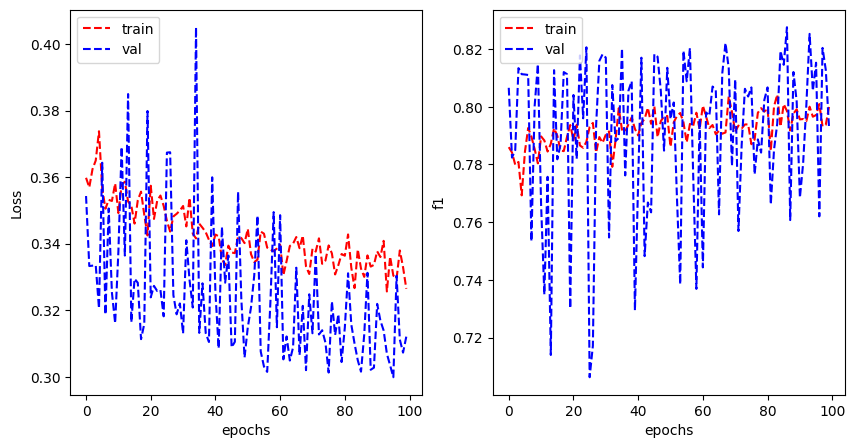

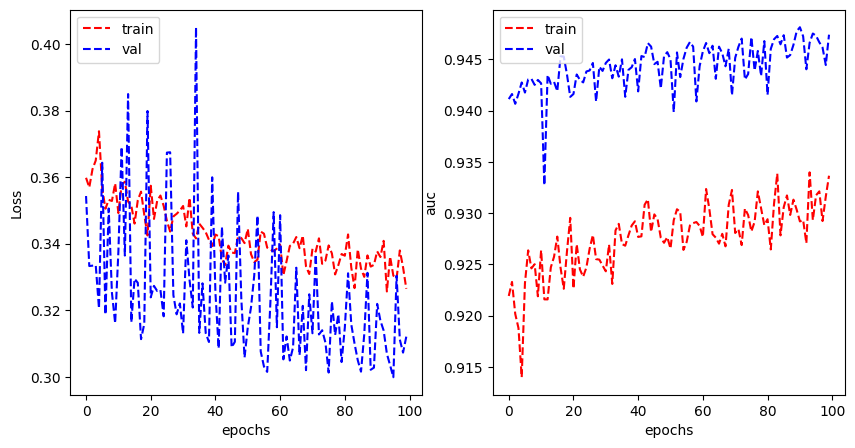

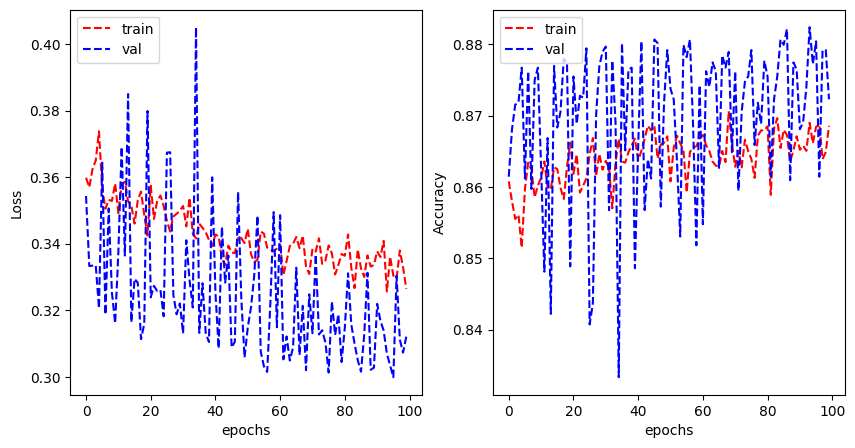

In [ ]:
plot_learning_curve(VGG_history_aug_t1.history['loss'], VGG_history_aug_t1.history['val_loss'], VGG_history_aug_t1.history['f1_m'], VGG_history_aug_t1.history['val_f1_m'], metric_name='f1')
plot_learning_curve(VGG_history_aug_t1.history['loss'], VGG_history_aug_t1.history['val_loss'], VGG_history_aug_t1.history['auc'], VGG_history_aug.history['val_auc'], metric_name='auc')
plot_learning_curve(VGG_history_aug_t1.history['loss'], VGG_history_aug_t1.history['val_loss'], VGG_history_aug_t1.history['binary_accuracy'], VGG_history_aug.history['val_binary_accuracy'], metric_name='Accuracy')

In [ ]:
VGG_model_aug_t1.evaluate(test_gen)

64/64 [==============================] - 6s 98ms/step - loss: 0.2880 - f1_m: 0.8216 - precision_m: 0.8940 - recall_m: 0.7652 - binary_accuracy: 0.8891 - auc: 0.9508


[0.28798601031303406,
 0.8216109871864319,
 0.893991231918335,
 0.7651790976524353,
 0.889053225517273,
 0.9507673978805542]

## 7.3.1 - Increasing layer count to deal with underfitting

In [ ]:
reg_lambda = 0.001

VGG_model_aug_t1_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

In [ ]:
VGG_model_aug_t1_1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[f1_m, precision_m, recall_m, tf.keras.metrics.BinaryAccuracy(), 'AUC'])

In [ ]:
VGG_history_aug_t1_1 = VGG_model_aug_t1_1.fit(train_gen, validation_data=val_gen, epochs=80, verbose=0)

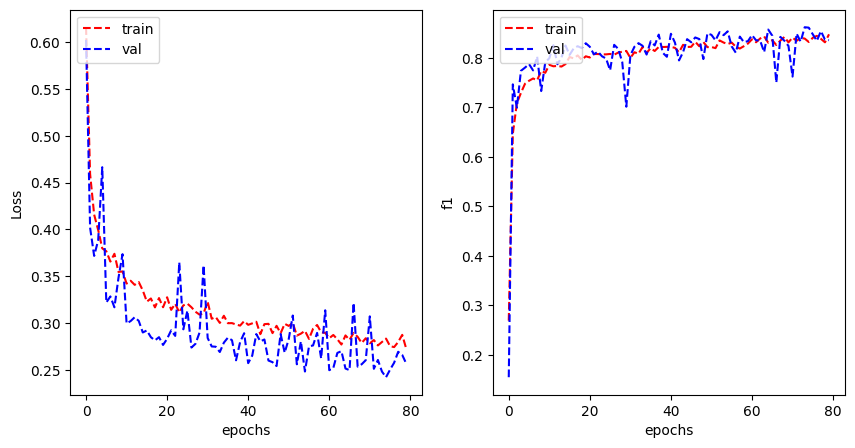

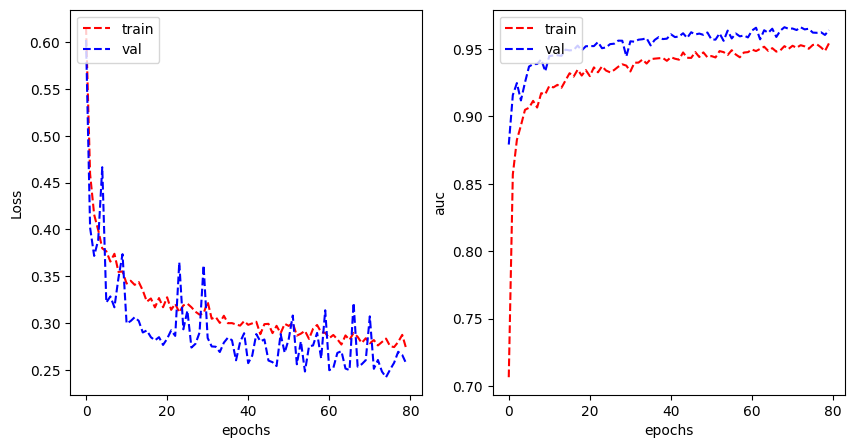

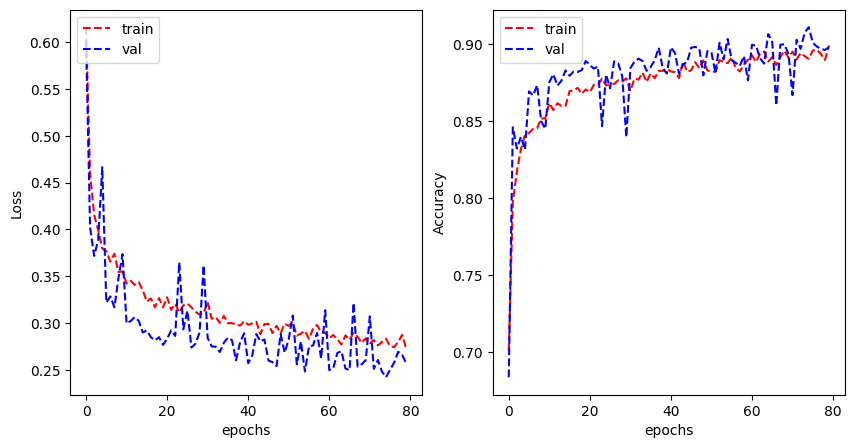

In [ ]:
plot_learning_curve(VGG_history_aug_t1_1.history['loss'], VGG_history_aug_t1_1.history['val_loss'], VGG_history_aug_t1_1.history['f1_m'], VGG_history_aug_t1_1.history['val_f1_m'], metric_name='f1')
plot_learning_curve(VGG_history_aug_t1_1.history['loss'], VGG_history_aug_t1_1.history['val_loss'], VGG_history_aug_t1_1.history['auc'], VGG_history_aug_t1_1.history['val_auc'], metric_name='auc')
plot_learning_curve(VGG_history_aug_t1_1.history['loss'], VGG_history_aug_t1_1.history['val_loss'], VGG_history_aug_t1_1.history['binary_accuracy'], VGG_history_aug_t1_1.history['val_binary_accuracy'], metric_name='Accuracy')

In [ ]:
VGG_model_aug_t1_1.evaluate(test_gen)

64/64 [==============================] - 4s 66ms/step - loss: 0.2880 - f1_m: 0.8253 - precision_m: 0.8994 - recall_m: 0.7696 - binary_accuracy: 0.8891 - auc: 0.9508


[0.28798604011535645,
 0.8253074288368225,
 0.8994296193122864,
 0.7695978879928589,
 0.889053225517273,
 0.9507673978805542]

## 7.4 - Performance evaluation

# 8 - Investigating using extraData to improve cell-type classification

We identified in section 6 it may be possible to use the enhanced extraData to enlarge the size of the training set for the Task 2 model, but given the ~30% error rate, may not be worth using. To determine is this approach has value, We will train a new version of our final Task 2 model on the larger combined training set, then compare the results to the original Task 2 model.

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last', rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,  horizontal_flip=True, zoom_range=0.2).flow_from_dataframe(
        dataframe=train_combinedData,
        directory='./',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=64,
        class_mode='categorical')

val_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last', rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,  horizontal_flip=True, zoom_range=0.2).flow_from_dataframe(
        dataframe=val_combinedData,
        directory='./',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=64,
        class_mode='categorical')

test_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last', rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,  horizontal_flip=True, zoom_range=0.2).flow_from_dataframe(
        dataframe=test_combinedData,
        directory='./',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=64,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 4 classes.
Found 4056 validated image filenames belonging to 4 classes.
Found 4056 validated image filenames belonging to 4 classes.


In [ ]:
reg_lambda = 0.01

VGG_model_aug_v2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
VGG_model_aug_v2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[f1_m, precision_m, recall_m, 'categorical_accuracy'])

In [ ]:
VGG_history_aug_v2 = VGG_model_aug_v2.fit(train_gen, validation_data=val_gen, epochs=75, verbose=0)

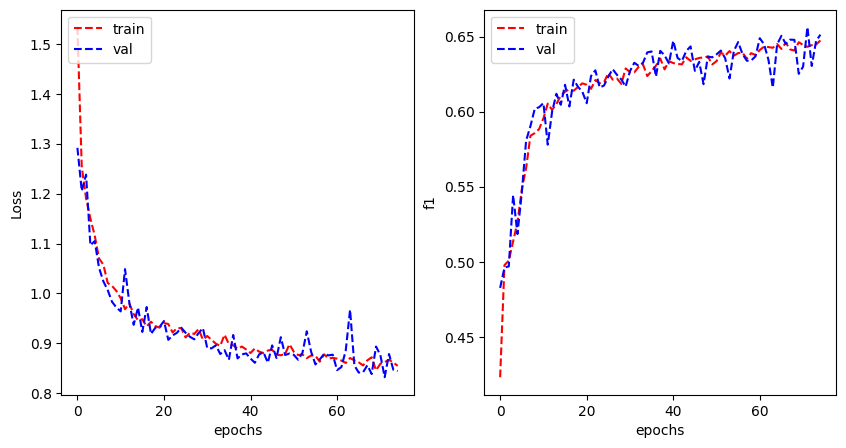

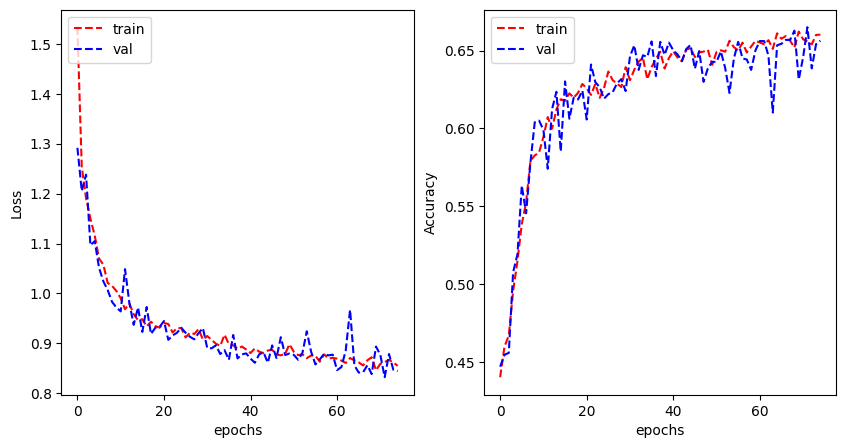

In [ ]:
plot_learning_curve(VGG_history_aug_v2.history['loss'], VGG_history_aug_v2.history['val_loss'], VGG_history_aug_v2.history['f1_m'], VGG_history_aug_v2.history['val_f1_m'], metric_name='f1')
plot_learning_curve(VGG_history_aug_v2.history['loss'], VGG_history_aug_v2.history['val_loss'], VGG_history_aug_v2.history['categorical_accuracy'], VGG_history_aug_v2.history['val_categorical_accuracy'], metric_name='Accuracy')

In [ ]:
VGG_model_aug_v2.evaluate(test_gen)

64/64 [==============================] - 8s 127ms/step - loss: 0.8506 - f1_m: 0.6479 - precision_m: 0.5666 - recall_m: 0.7577 - categorical_accuracy: 0.6635


[0.8506306409835815,
 0.6479158997535706,
 0.5665774345397949,
 0.7577311396598816,
 0.6634615659713745]